In [1]:
# STEP 1: IMPORT LIBRARIES
# ============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [2]:

# STEP 2: DATA LOADING
print("=" * 80)
print("STEP 2: LOADING DATA")
print("=" * 80)

# Load the datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"\nFirst few rows of training data:")
print(train_df.head())


STEP 2: LOADING DATA
Training data shape: (750000, 9)
Test data shape: (250000, 8)

First few rows of training data:
   id     Sex  Age  Height  Weight  Duration  Heart_Rate  Body_Temp  Calories
0   0    male   36   189.0    82.0      26.0       101.0       41.0     150.0
1   1  female   64   163.0    60.0       8.0        85.0       39.7      34.0
2   2  female   51   161.0    64.0       7.0        84.0       39.8      29.0
3   3    male   20   192.0    90.0      25.0       105.0       40.7     140.0
4   4  female   38   166.0    61.0      25.0       102.0       40.6     146.0


In [3]:
# STEP 3: EXPLORATORY DATA ANALYSIS (EDA)

print("\n" + "=" * 80)
print("STEP 3: EXPLORATORY DATA ANALYSIS")
print("=" * 80)

# 3.1: Basic Information
print("\n3.1: Dataset Info")
print("-" * 80)
print(train_df.info())

# 3.2: Statistical Summary
print("\n3.2: Statistical Summary")
print("-" * 80)
print(train_df.describe())



STEP 3: EXPLORATORY DATA ANALYSIS

3.1: Dataset Info
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB
None

3.2: Statistical Summary
--------------------------------------------------------------------------------
                  id            Age         Height         Weight  \
count  750000.000000  750000.000000  750000.00000

In [4]:

# 3.3: Check for Missing Values
print("\n3.3: Missing Values")
print("-" * 80)
missing_train = train_df.isnull().sum()
missing_test = test_df.isnull().sum()
print("Training set missing values:")
print(missing_train[missing_train > 0] if missing_train.sum() > 0 else "No missing values")
print("\nTest set missing values:")
print(missing_test[missing_test > 0] if missing_test.sum() > 0 else "No missing values")

# 3.4: Check for Duplicates
print("\n3.4: Duplicate Rows")
print("-" * 80)
print(f"Training set duplicates: {train_df.duplicated().sum()}")
print(f"Test set duplicates: {test_df.duplicated().sum()}")

# 3.5: Target Variable Analysis
print("\n3.5: Target Variable Analysis (Calories)")
print("-" * 80)
print(train_df['Calories'].describe()) 

# Define columns - these will be used throughout the pipeline
id_col = 'id'
target_col = 'Calories'
feature_cols = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']

print(f"Number of features: {len(feature_cols)}")
print(f"Features: {feature_cols}")

# Identify numeric and categorical features
numeric_features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
categorical_features = ['Sex']

print(f"\nNumeric features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")


3.3: Missing Values
--------------------------------------------------------------------------------
Training set missing values:
No missing values

Test set missing values:
No missing values

3.4: Duplicate Rows
--------------------------------------------------------------------------------
Training set duplicates: 0
Test set duplicates: 0

3.5: Target Variable Analysis (Calories)
--------------------------------------------------------------------------------
count    750000.000000
mean         88.282781
std          62.395349
min           1.000000
25%          34.000000
50%          77.000000
75%         136.000000
max         314.000000
Name: Calories, dtype: float64
Number of features: 7
Features: ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']

Numeric features (6): ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
Categorical features (1): ['Sex']


Target distribution plot saved as 'target_distribution.png'
Creating Basic Correlation Heatmap...


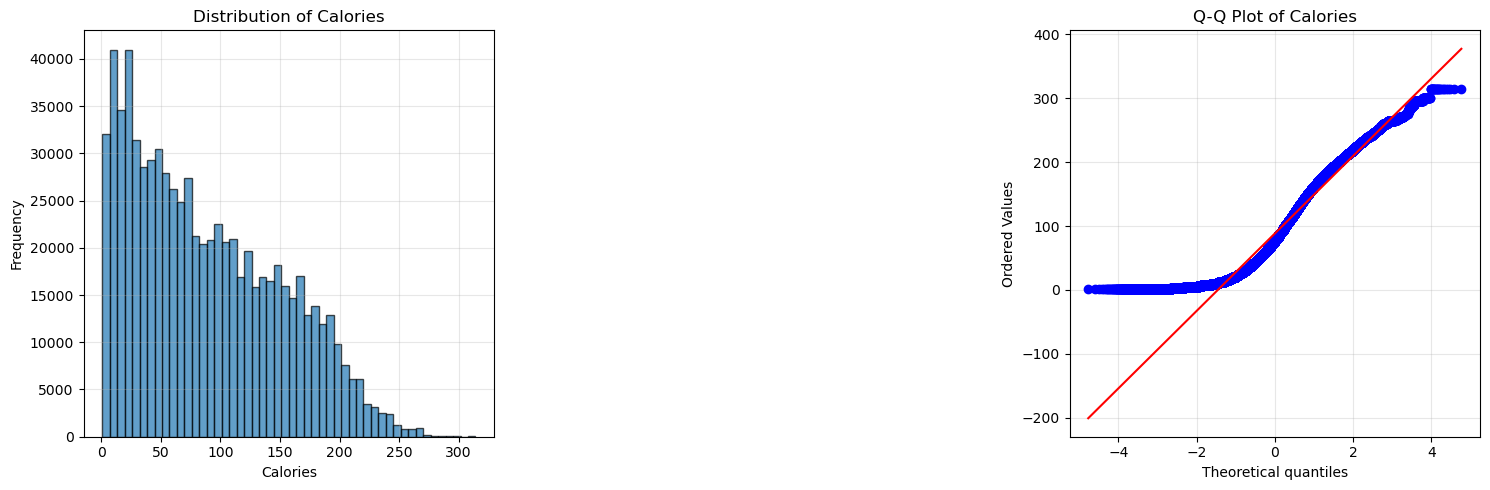

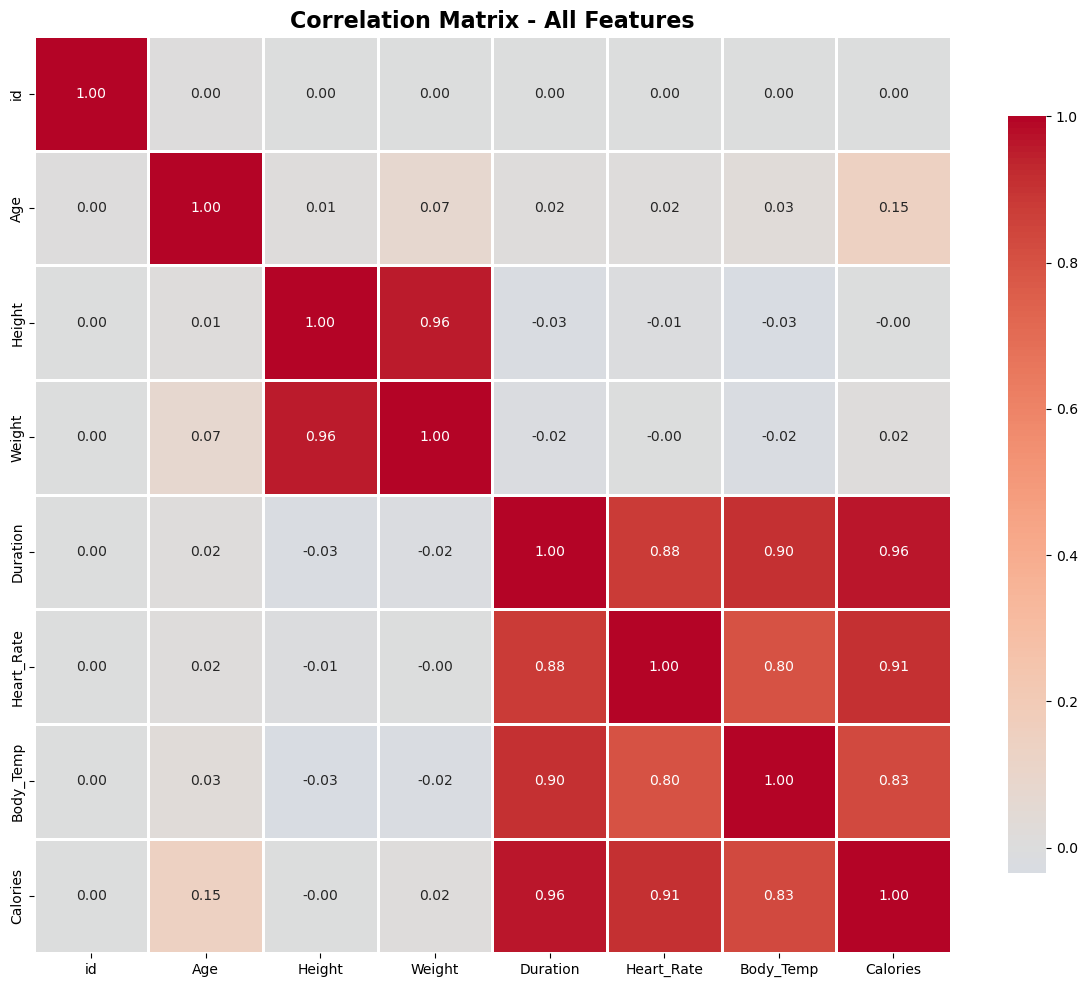

In [5]:
# Visualize target distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(train_df['Calories'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.title('Distribution of Calories')
plt.grid(True, alpha=0.3)



plt.subplot(1, 3, 3)
from scipy import stats
stats.probplot(train_df['Calories'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Calories')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('target_distribution.png', dpi=300, bbox_inches='tight')
print("Target distribution plot saved as 'target_distribution.png'")

print("Creating Basic Correlation Heatmap...")

# Select only numeric columns
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()

# Calculate correlation matrix
correlation_matrix = train_df[numeric_cols].corr()

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True,           # Show correlation values
            fmt='.2f',            # Format to 2 decimal places
            cmap='coolwarm',      # Color scheme (red = positive, blue = negative)
            center=0,             # Center colormap at 0
            square=True,          # Make cells square-shaped
            linewidths=1,         # Add lines between cells
            cbar_kws={"shrink": 0.8})  # Adjust colorbar size

plt.title('Correlation Matrix - All Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_heatmap_basic.png', dpi=300, bbox_inches='tight')
plt.show()


In [6]:
print("\n" + "=" * 80)
print("STEP 4: FEATURE ENGINEERING")
print("=" * 80)

def engineer_features(df):
    """Create new features from existing ones"""
    df = df.copy()
    
    # Example feature engineering (customize based on actual features)
    # Common features in calorie prediction datasets:
    
    #  BMI-related features exist
    if 'Weight' in df.columns and 'Height' in df.columns:
        df['BMI'] = df['Weight'] / ((df['Height'] / 100) ** 2)
        print("Created BMI feature")
    
    # Age exists, create age groups
    if 'Age' in df.columns:
        df['Age_Squared'] = df['Age'] ** 2
        df['Age_Group'] = pd.cut(df['Age'], bins=[0, 25, 40, 60, 100], 
                                  labels=['Young', 'Middle', 'Senior', 'Elderly'])
        print("Created Age-based features")
    
    # If Duration exists
    if 'Duration' in df.columns:
        df['Duration_Squared'] = df['Duration'] ** 2
        print("Created Duration squared feature")
    
    # If Heart Rate exists
    if 'Heart_Rate' in df.columns and 'Age' in df.columns:
        df['Heart_Rate_Pct_Max'] = df['Heart_Rate'] / (220 - df['Age'])
        print("Created Heart Rate percentage of max feature")
    
    # Interaction features
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if 'Duration' in numeric_cols and 'Weight' in numeric_cols:
        df['Duration_Weight_Interaction'] = df['Duration'] * df['Weight']
        print("Created Duration-Weight interaction")
    
    return df

# Apply feature engineering
train_df_engineered = engineer_features(train_df)
test_df_engineered = engineer_features(test_df)

print(f"\nNew training data shape: {train_df_engineered.shape}")
print(f"New test data shape: {test_df_engineered.shape}")


STEP 4: FEATURE ENGINEERING
Created BMI feature
Created Age-based features
Created Duration squared feature
Created Heart Rate percentage of max feature
Created Duration-Weight interaction
Created BMI feature
Created Age-based features
Created Duration squared feature
Created Heart Rate percentage of max feature
Created Duration-Weight interaction

New training data shape: (750000, 15)
New test data shape: (250000, 14)


In [7]:
# STEP 5: DATA PREPROCESSING
# ============================================================================
print("\n" + "=" * 80)
print("STEP 5: DATA PREPROCESSING")
print("=" * 80)

# 5.1: Handle Categorical Variables
print("\n5.1: Encoding Categorical Variables")
print("-" * 80)

# Get updated feature list
feature_cols_updated = [col for col in train_df_engineered.columns 
                        if col not in [id_col, target_col]]

categorical_features_updated = train_df_engineered[feature_cols_updated].select_dtypes(
    include=['object', 'category']).columns.tolist()

if len(categorical_features_updated) > 0:
    print(f"Categorical features to encode: {categorical_features_updated}")
    
    # One-hot encoding
    train_df_encoded = pd.get_dummies(train_df_engineered, 
                                      columns=categorical_features_updated, 
                                      drop_first=True)
    test_df_encoded = pd.get_dummies(test_df_engineered, 
                                     columns=categorical_features_updated, 
                                     drop_first=True)
    
    # Align train and test columns
    train_cols = set(train_df_encoded.columns)
    test_cols = set(test_df_encoded.columns)
    
    # Add missing columns to test
    for col in train_cols - test_cols:
        if col not in [target_col]:
            test_df_encoded[col] = 0
    
    # Remove extra columns from test
    for col in test_cols - train_cols:
        if col != id_col:
            test_df_encoded = test_df_encoded.drop(col, axis=1)
    
    print(f"Encoded training shape: {train_df_encoded.shape}")
    print(f"Encoded test shape: {test_df_encoded.shape}")
else:
    train_df_encoded = train_df_engineered.copy()
    test_df_encoded = test_df_engineered.copy()
    print("No categorical features to encode")

# 5.2: Prepare features and target
print("\n5.2: Preparing Features and Target")
print("-" * 80)

X = train_df_encoded.drop([id_col, target_col], axis=1)
y = train_df_encoded[target_col]
X_test_final = test_df_encoded.drop([id_col], axis=1)

# Ensure same column order
X_test_final = X_test_final[X.columns]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Test features shape: {X_test_final.shape}")

# 5.3: Split data
print("\n5.3: Splitting Data")
print("-" * 80)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

# 5.4: Feature Scaling
print("\n5.4: Feature Scaling")
print("-" * 80)

# Try both StandardScaler and RobustScaler
scaler = StandardScaler()
# scaler = RobustScaler()  # Alternative: more robust to outliers

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_final)

print("Features scaled using StandardScaler")
print(f"Scaled training set shape: {X_train_scaled.shape}")



STEP 5: DATA PREPROCESSING

5.1: Encoding Categorical Variables
--------------------------------------------------------------------------------
Categorical features to encode: ['Sex', 'Age_Group']
Encoded training shape: (750000, 17)
Encoded test shape: (250000, 16)

5.2: Preparing Features and Target
--------------------------------------------------------------------------------
Features shape: (750000, 15)
Target shape: (750000,)
Test features shape: (250000, 15)

5.3: Splitting Data
--------------------------------------------------------------------------------
Training set: (600000, 15)
Validation set: (150000, 15)

5.4: Feature Scaling
--------------------------------------------------------------------------------
Features scaled using StandardScaler
Scaled training set shape: (600000, 15)


In [8]:
# STEP 6: MODEL TRAINING - BASELINE RIDGE REGRESSION
# ============================================================================
print("\n" + "=" * 80)
print("STEP 6: BASELINE RIDGE REGRESSION MODEL")
print("=" * 80)

# 6.1: Train baseline model with default alpha
print("\n6.1: Training Baseline Model (alpha=1.0)")
print("-" * 80)

baseline_ridge = Ridge(alpha=1.0, random_state=RANDOM_STATE)
baseline_ridge.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred_baseline = baseline_ridge.predict(X_train_scaled)
y_val_pred_baseline = baseline_ridge.predict(X_val_scaled)

# Evaluate baseline
train_rmse_baseline = np.sqrt(mean_squared_error(y_train, y_train_pred_baseline))
val_rmse_baseline = np.sqrt(mean_squared_error(y_val, y_val_pred_baseline))
train_mae_baseline = mean_absolute_error(y_train, y_train_pred_baseline)
val_mae_baseline = mean_absolute_error(y_val, y_val_pred_baseline)
train_r2_baseline = r2_score(y_train, y_train_pred_baseline)
val_r2_baseline = r2_score(y_val, y_val_pred_baseline)

print("\nBaseline Model Performance:")
print(f"Training RMSE: {train_rmse_baseline:.4f}")
print(f"Validation RMSE: {val_rmse_baseline:.4f}")
print(f"Training MAE: {train_mae_baseline:.4f}")
print(f"Validation MAE: {val_mae_baseline:.4f}")
print(f"Training R²: {train_r2_baseline:.4f}")
print(f"Validation R²: {val_r2_baseline:.4f}")


STEP 6: BASELINE RIDGE REGRESSION MODEL

6.1: Training Baseline Model (alpha=1.0)
--------------------------------------------------------------------------------

Baseline Model Performance:
Training RMSE: 7.8467
Validation RMSE: 7.7996
Training MAE: 5.6473
Validation MAE: 5.6368
Training R²: 0.9842
Validation R²: 0.9843


In [9]:
# STEP 7: HYPERPARAMETER TUNING
# ============================================================================
print("\n" + "=" * 80)
print("STEP 7: HYPERPARAMETER TUNING")
print("=" * 80)

# 7.1: RidgeCV for quick alpha selection
print("\n7.1: Using RidgeCV for Alpha Selection")
print("-" * 80)

alphas = np.logspace(-3, 3, 100)
ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_scaled, y_train)

print(f"Best alpha from RidgeCV: {ridge_cv.alpha_:.4f}")

# 7.2: Grid Search for comprehensive tuning
print("\n7.2: Grid Search with Cross-Validation")
print("-" * 80)

param_grid = {
    'alpha': np.logspace(-3, 3, 50),
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'saga']
}

kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid_search = GridSearchCV(
    estimator=Ridge(random_state=RANDOM_STATE),
    param_grid=param_grid,
    cv=kfold,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation RMSE: {np.sqrt(-grid_search.best_score_):.4f}")


STEP 7: HYPERPARAMETER TUNING

7.1: Using RidgeCV for Alpha Selection
--------------------------------------------------------------------------------
Best alpha from RidgeCV: 0.0010

7.2: Grid Search with Cross-Validation
--------------------------------------------------------------------------------
Fitting 5 folds for each of 250 candidates, totalling 1250 fits

Best parameters: {'alpha': 0.0517947467923121, 'solver': 'auto'}
Best cross-validation RMSE: 7.8470


In [10]:
# STEP 8: FINAL MODEL TRAINING
# ============================================================================
print("\n" + "=" * 80)
print("STEP 8: TRAINING FINAL MODEL")
print("=" * 80)

best_ridge = grid_search.best_estimator_

# Make predictions with best model
y_train_pred_final = best_ridge.predict(X_train_scaled)
y_val_pred_final = best_ridge.predict(X_val_scaled)

# Evaluate final model
train_rmse_final = np.sqrt(mean_squared_error(y_train, y_train_pred_final))
val_rmse_final = np.sqrt(mean_squared_error(y_val, y_val_pred_final))
train_mae_final = mean_absolute_error(y_train, y_train_pred_final)
val_mae_final = mean_absolute_error(y_val, y_val_pred_final)
train_r2_final = r2_score(y_train, y_train_pred_final)
val_r2_final = r2_score(y_val, y_val_pred_final)

print("\nFinal Model Performance:")
print(f"Training RMSE: {train_rmse_final:.4f}")
print(f"Validation RMSE: {val_rmse_final:.4f}")
print(f"Training MAE: {train_mae_final:.4f}")
print(f"Validation MAE: {val_mae_final:.4f}")
print(f"Training R²: {train_r2_final:.4f}")
print(f"Validation R²: {val_r2_final:.4f}")

print("\nImprovement over Baseline:")
print(f"RMSE improvement: {((val_rmse_baseline - val_rmse_final) / val_rmse_baseline * 100):.2f}%")
print(f"MAE improvement: {((val_mae_baseline - val_mae_final) / val_mae_baseline * 100):.2f}%")


STEP 8: TRAINING FINAL MODEL

Final Model Performance:
Training RMSE: 7.8467
Validation RMSE: 7.7996
Training MAE: 5.6474
Validation MAE: 5.6369
Training R²: 0.9842
Validation R²: 0.9843

Improvement over Baseline:
RMSE improvement: 0.00%
MAE improvement: -0.00%



STEP 9: MODEL VALIDATION

9.1: Cross-Validation Analysis
--------------------------------------------------------------------------------
Cross-validation RMSE scores: [7.88869739 7.84477398 7.85283521 7.8342178  7.81560985]
Mean CV RMSE: 7.8472 (+/- 0.0484)

9.2: Residual Analysis
--------------------------------------------------------------------------------
Model validation plots saved as 'model_validation.png'

Residuals Mean: 0.0001
Residuals Std: 7.7997


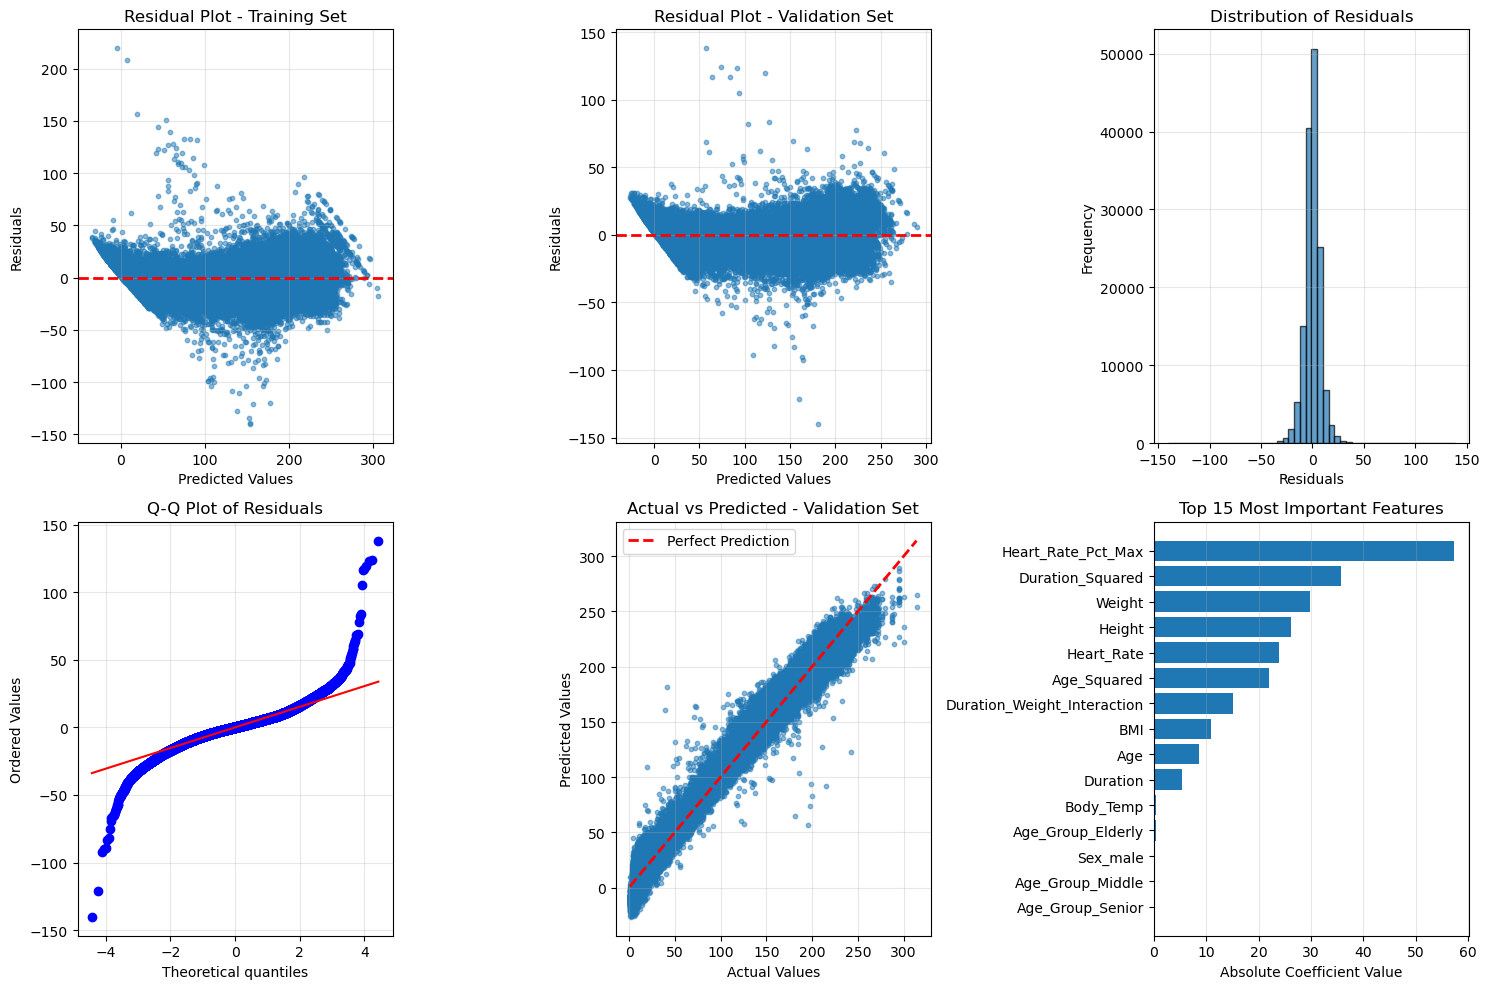

In [11]:
# STEP 9: MODEL VALIDATION
# ============================================================================
print("\n" + "=" * 80)
print("STEP 9: MODEL VALIDATION")
print("=" * 80)

# 9.1: Cross-validation scores
print("\n9.1: Cross-Validation Analysis")
print("-" * 80)

cv_scores = cross_val_score(
    best_ridge, X_train_scaled, y_train, 
    cv=5, scoring='neg_mean_squared_error', n_jobs=-1
)

cv_rmse_scores = np.sqrt(-cv_scores)
print(f"Cross-validation RMSE scores: {cv_rmse_scores}")
print(f"Mean CV RMSE: {cv_rmse_scores.mean():.4f} (+/- {cv_rmse_scores.std() * 2:.4f})")

# 9.2: Residual Analysis
print("\n9.2: Residual Analysis")
print("-" * 80)

residuals_train = y_train - y_train_pred_final
residuals_val = y_val - y_val_pred_final

plt.figure(figsize=(15, 10))

# Residuals vs Predicted
plt.subplot(2, 3, 1)
plt.scatter(y_train_pred_final, residuals_train, alpha=0.5, s=10)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot - Training Set')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.scatter(y_val_pred_final, residuals_val, alpha=0.5, s=10)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot - Validation Set')
plt.grid(True, alpha=0.3)

# Distribution of Residuals
plt.subplot(2, 3, 3)
plt.hist(residuals_val, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True, alpha=0.3)

# Q-Q Plot
plt.subplot(2, 3, 4)
stats.probplot(residuals_val, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.grid(True, alpha=0.3)

# Actual vs Predicted
plt.subplot(2, 3, 5)
plt.scatter(y_val, y_val_pred_final, alpha=0.5, s=10)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted - Validation Set')
plt.legend()
plt.grid(True, alpha=0.3)

# Feature Importance (Ridge coefficients)
plt.subplot(2, 3, 6)
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': np.abs(best_ridge.coef_)
}).sort_values('importance', ascending=False).head(15)

plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('model_validation.png', dpi=300, bbox_inches='tight')
print("Model validation plots saved as 'model_validation.png'")

print(f"\nResiduals Mean: {residuals_val.mean():.4f}")
print(f"Residuals Std: {residuals_val.std():.4f}")

In [12]:
# STEP 10: RETRAIN ON FULL DATA AND MAKE PREDICTIONS
# ============================================================================
print("\n" + "=" * 80)
print("STEP 10: FINAL MODEL RETRAINING AND PREDICTIONS")
print("=" * 80)

# Retrain on full training data
print("\nRetraining on full training dataset...")
X_full_scaled = scaler.fit_transform(X)

final_model = Ridge(**grid_search.best_params_, random_state=RANDOM_STATE)
final_model.fit(X_full_scaled, y)

# Scale test data
X_test_full_scaled = scaler.transform(X_test_final)

# Make predictions on test set
test_predictions = final_model.predict(X_test_full_scaled)

print(f"Test predictions shape: {test_predictions.shape}")
print(f"Test predictions range: [{test_predictions.min():.2f}, {test_predictions.max():.2f}]")


STEP 10: FINAL MODEL RETRAINING AND PREDICTIONS

Retraining on full training dataset...
Test predictions shape: (250000,)
Test predictions range: [-36.08, 290.32]


In [ ]:
# STEP 11: CREATE SUBMISSION FILE
# ============================================================================
print("\n" + "=" * 80)
print("STEP 11: CREATING SUBMISSION FILE")
print("=" * 80)

submission_2 = pd.DataFrame({
    'id': test_df_encoded['id'],
    'Calories': test_predictions
})

submission_2.to_csv('submission_2.csv', index=False)
print("\nSubmission file created: 'submission_2.csv'")
print(f"Submission shape: {submission_2.shape}")
print("\nFirst few predictions:")
print(submission_2.head(10))


STEP 11: CREATING SUBMISSION FILE

Submission file created: 'submission_2.csv'
Submission shape: (250000, 2)

First few predictions:
       id    Calories
0  750000   27.973560
1  750001  111.312564
2  750002   86.115881
3  750003  123.581324
4  750004   71.998660
5  750005   15.876485
6  750006   42.171844
7  750007   -1.063716
8  750008    5.753958
9  750009  200.375580
